In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:

H_DIM = 20

IMAGE_DIM = (64, 64)

EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 128

In [3]:

dataset_url = "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
dataset_path = "dsprites.npz"

if not os.path.exists(dataset_path):
    print("Downloading dsprites dataset...")

    !wget -q -O {dataset_path} {dataset_url}
    print("Download complete.")
else:
    print("Dataset already downloaded.")


class DSpritesDataset(Dataset):
    def __init__(self, npz_path):
        print("Loading dataset with memory mapping (mmap_mode)...")
        data = np.load(npz_path, mmap_mode='r')

        self.images = data['imgs']
        print(f"Dataset loaded. Total samples: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image_np = self.images[idx]


        image_tensor = torch.from_numpy(image_np.astype(np.float32)).unsqueeze(0)

        return image_tensor


full_dataset = DSpritesDataset(dataset_path)
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Training samples: {len(train_dataset)}")



Download complete.
Loading dataset with memory mapping (mmap_mode)...
Dataset loaded. Total samples: 737280
DataLoaders created. Training samples: 663552


In [4]:

class VAE(nn.Module):
    def __init__(self, h_dim):
        super(VAE, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )


        self.fc_mu = nn.Linear(8192, h_dim)
        self.fc_logvar = nn.Linear(8192, h_dim)


        self.decoder_input = nn.Linear(h_dim, 8192)


        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_input(z))
        h = h.view(-1, 128, 8, 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [5]:

def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x.view(-1, 64*64), x.view(-1, 64*64), reduction='sum')


    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = (BCE + KLD) / x.size(0)

    avg_bce = BCE / x.size(0)
    avg_kld = KLD / x.size(0)

    return total_loss, avg_bce, avg_kld

In [6]:

model = VAE(h_dim=H_DIM).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history_total_loss = []
history_recon_loss = []
history_kl_loss = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()

    epoch_total_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)

        recon_batch, mu, logvar = model(data)

        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_total_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

    avg_total_loss = epoch_total_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    history_total_loss.append(avg_total_loss)
    history_recon_loss.append(avg_recon_loss)
    history_kl_loss.append(avg_kl_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Total Loss: {avg_total_loss:.4f}, "
          f"Recon Loss: {avg_recon_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

print("Training finished.")

Starting training...
Epoch [1/50], Total Loss: 98.9818, Recon Loss: 66.0452, KL Loss: 32.9366
Epoch [2/50], Total Loss: 68.0610, Recon Loss: 35.6141, KL Loss: 32.4469
Epoch [3/50], Total Loss: 63.3760, Recon Loss: 31.1794, KL Loss: 32.1965
Epoch [4/50], Total Loss: 59.9931, Recon Loss: 27.6437, KL Loss: 32.3494
Epoch [5/50], Total Loss: 57.7913, Recon Loss: 25.4609, KL Loss: 32.3304
Epoch [6/50], Total Loss: 56.2154, Recon Loss: 24.0465, KL Loss: 32.1689
Epoch [7/50], Total Loss: 54.9401, Recon Loss: 23.0226, KL Loss: 31.9175
Epoch [8/50], Total Loss: 54.0233, Recon Loss: 22.3707, KL Loss: 31.6526
Epoch [9/50], Total Loss: 53.1927, Recon Loss: 21.8115, KL Loss: 31.3812
Epoch [10/50], Total Loss: 52.6118, Recon Loss: 21.4400, KL Loss: 31.1718
Epoch [11/50], Total Loss: 52.0170, Recon Loss: 21.0245, KL Loss: 30.9925
Epoch [12/50], Total Loss: 51.5740, Recon Loss: 20.7440, KL Loss: 30.8299
Epoch [13/50], Total Loss: 51.1759, Recon Loss: 20.4832, KL Loss: 30.6927
Epoch [14/50], Total Loss:


--- بخش ۷: خروجی‌های نهایی ---
1. Plotting training losses...


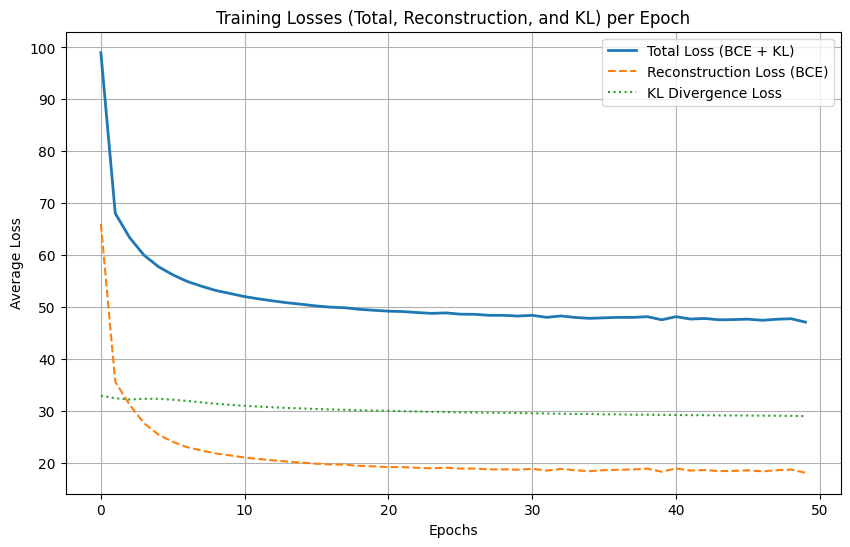

2. Displaying 8 random test samples and their reconstructions...


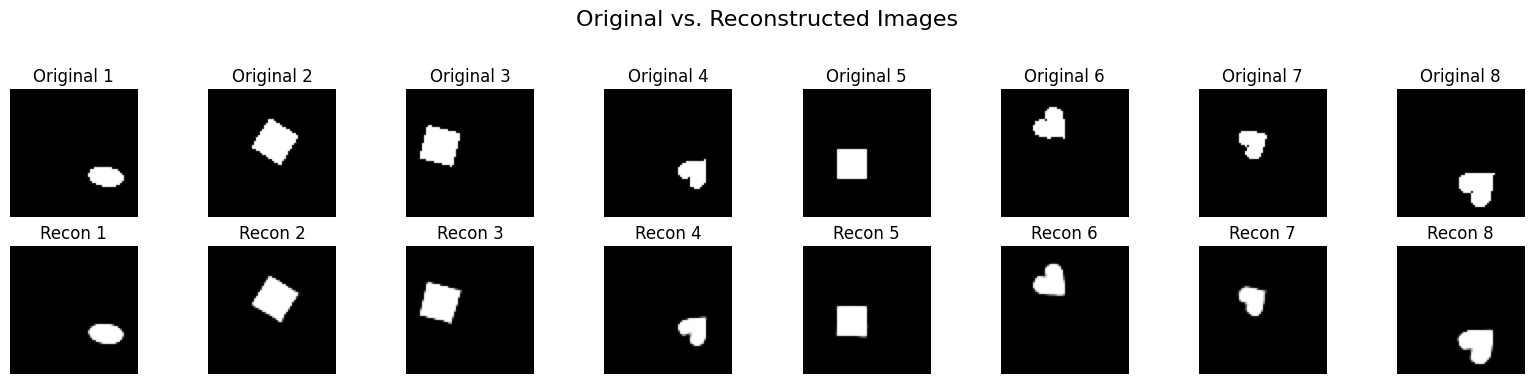

In [7]:

print("\n--- بخش ۷: خروجی‌های نهایی ---")

print("1. Plotting training losses...")
plt.figure(figsize=(10, 6))
plt.plot(history_total_loss, label='Total Loss (BCE + KL)', linewidth=2)
plt.plot(history_recon_loss, label='Reconstruction Loss (BCE)', linestyle='--')
plt.plot(history_kl_loss, label='KL Divergence Loss', linestyle=':')
plt.title('Training Losses (Total, Reconstruction, and KL) per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

print("2. Displaying 8 random test samples and their reconstructions...")


test_images_batch = next(iter(test_loader)).to(device)
test_images = test_images_batch[:8]

model.eval()

with torch.no_grad():
    recon_images, _, _ = model(test_images)

originals = test_images.cpu().numpy().squeeze()
reconstructions = recon_images.cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Original vs. Reconstructed Images', fontsize=16)

for i in range(8):

    axes[0, i].imshow(originals[i], cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructions[i], cmap='gray')
    axes[1, i].set_title(f"Recon {i+1}")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()